In [1]:
from scipy.stats import vonmises,skewnorm
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from tqdm import tqdm
import numpy as np
import ot

from lcot import LCOT
from lcot.measures import measure,empirical_measure,ot_1d
from lcot.visualize import plot_circle_pdf

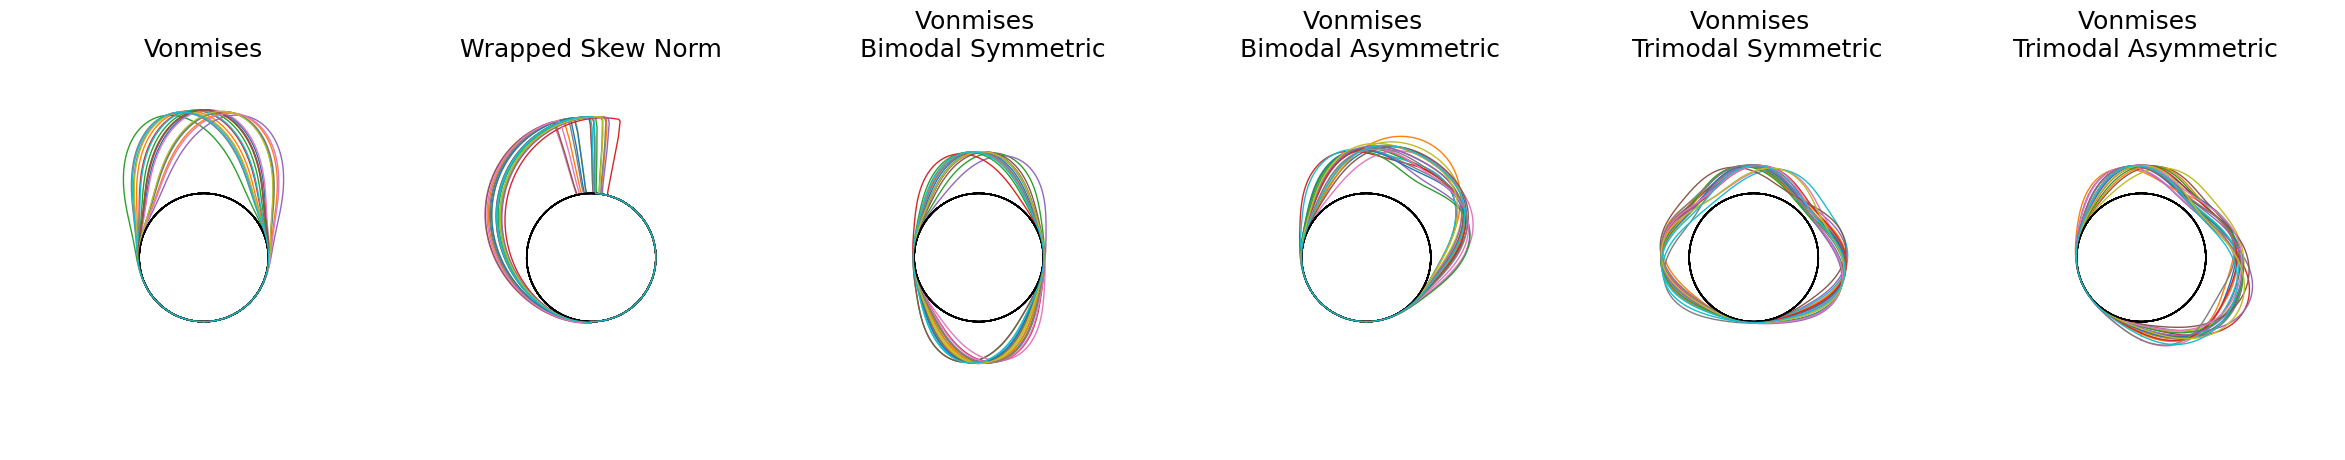

In [27]:
#@title # Generate Densities
fig , ax = plt.subplots(1,6,figsize=(30,5))
# Minimum and Maximum number of samples
min_ = 50
max_ = 100
# Initialize measures and labels
measures = []
label = []
# Number of measures per class
M = 20
x = np.linspace(-np.pi, np.pi, 500)
t = np.linspace(0, 1, 500)

# Parameters of the unimodal von Mises
loc = 0
kappa = 5
scale =.75
kappa_rand = 50
for i in range(M):
  mean_loc = vonmises(loc=0, kappa=kappa_rand).rvs(1)
  pdf = vonmises.pdf(mean_loc+loc, kappa, x)
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(0)
  plot_circle_pdf(t, pdf,scale=scale, alpha=1,ax=ax[0])

# Parameters of the Skew Norm
a = 100
for i in range(M):
  mean_loc = vonmises(loc=0, kappa=kappa_rand).rvs(1)
  rv = skewnorm(a, loc=mean_loc+loc, scale=1.)
  pdf = rv.pdf(x)
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(1)
  plot_circle_pdf(t,pdf,scale=scale,ax=ax[1])

## Parameters of von Mises bimodal
loc1 = 0
loc2 = np.pi
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(2)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/2
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/2
  pdf = vonmises_1_pdf + vonmises_2_pdf
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(2)
  plot_circle_pdf(t, pdf, scale=scale,alpha=1,ax=ax[2])


## Vonmises bimodal asymmetric
loc1 = 0
loc2 = -np.pi/3.
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(2)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/2
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/2
  pdf = vonmises_1_pdf + vonmises_2_pdf
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(3)
  plot_circle_pdf(t, pdf, alpha=1,scale=scale,ax=ax[3])


## Vonmises trimodal
loc1 = 0
loc2=np.pi/2
loc3=-np.pi*200/360
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(3)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/3
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/3
  vonmises_3_pdf = vonmises.pdf(loc3+mean_locs[2], kappa, x)/3
  pdf = vonmises_1_pdf + vonmises_2_pdf + vonmises_3_pdf  
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(4)
  plot_circle_pdf(t, pdf, scale=scale, alpha=1,ax=ax[4])

## Vonmises trimodal Asymmetric
loc1= 0
loc2=-np.pi/2,
loc3=-np.pi*270/360
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(3)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/3
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/3
  vonmises_3_pdf = vonmises.pdf(loc3+mean_locs[2], kappa, x)/3
  pdf = vonmises_1_pdf + vonmises_2_pdf + vonmises_3_pdf  
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(5)
  plot_circle_pdf(t, pdf, scale=scale, alpha=1,ax=ax[5])

label = np.array(label)
titles = [
    'Vonmises','Wrapped Skew Norm',
    'Vonmises \n Bimodal Symmetric','Vonmises \n Bimodal Asymmetric',
    'Vonmises \n Trimodal Symmetric','Vonmises \n Trimodal Asymmetric']
for i in range(6):
    ax[i].axis('off')
    ax[i].set_title(titles[i],fontsize=18)
    ax[i].set_ylim([-1.5,1.5])
    ax[i].set_xlim([-1.5,1.5])
plt.subplots_adjust(wspace=0, hspace=0)

In [28]:
#@title # Pairwise distances
lcot = LCOT(t)
mat_lin_COT = np.zeros([len(measures),len(measures)])
mat_COT = np.zeros([len(measures),len(measures)])
mat_OT = np.zeros([len(measures),len(measures)])
mat_euclidean = np.zeros([len(measures),len(measures)])
for i in tqdm(range(len(measures)-1)):
  for j in range(i+1,len(measures)):
    mat_lin_COT[i,j] = np.sqrt(lcot.cost(measures[i],measures[j]))
    mat_COT[i,j] = np.sqrt(ot.binary_search_circle(measures[i].samples, measures[j].samples, p=2))
    mat_OT[i,j] = ot_1d(measures[i].samples,measures[j].samples)
    min_sample = min(measures[i].samples.min(), measures[j].samples.min())
    max_sample = max(measures[i].samples.max(), measures[j].samples.max())
    h1, _ = np.histogram(measures[i].samples, bins=360, range=(min_sample, max_sample), density=True)
    h2, _ = np.histogram(measures[j].samples, bins=360, range=(min_sample, max_sample), density=True)
    mat_euclidean[i, j] = (np.sum((h1-h2)**2)/360)**0.5

mat_lin_COT = mat_lin_COT + mat_lin_COT.T
mat_COT = mat_COT + mat_COT.T
mat_OT = mat_OT + mat_OT.T
mat_euclidean = mat_euclidean + mat_euclidean.T


100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.69it/s]


/Users/kolous2/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/kolous2/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/kolous2/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/kolous2/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` wi

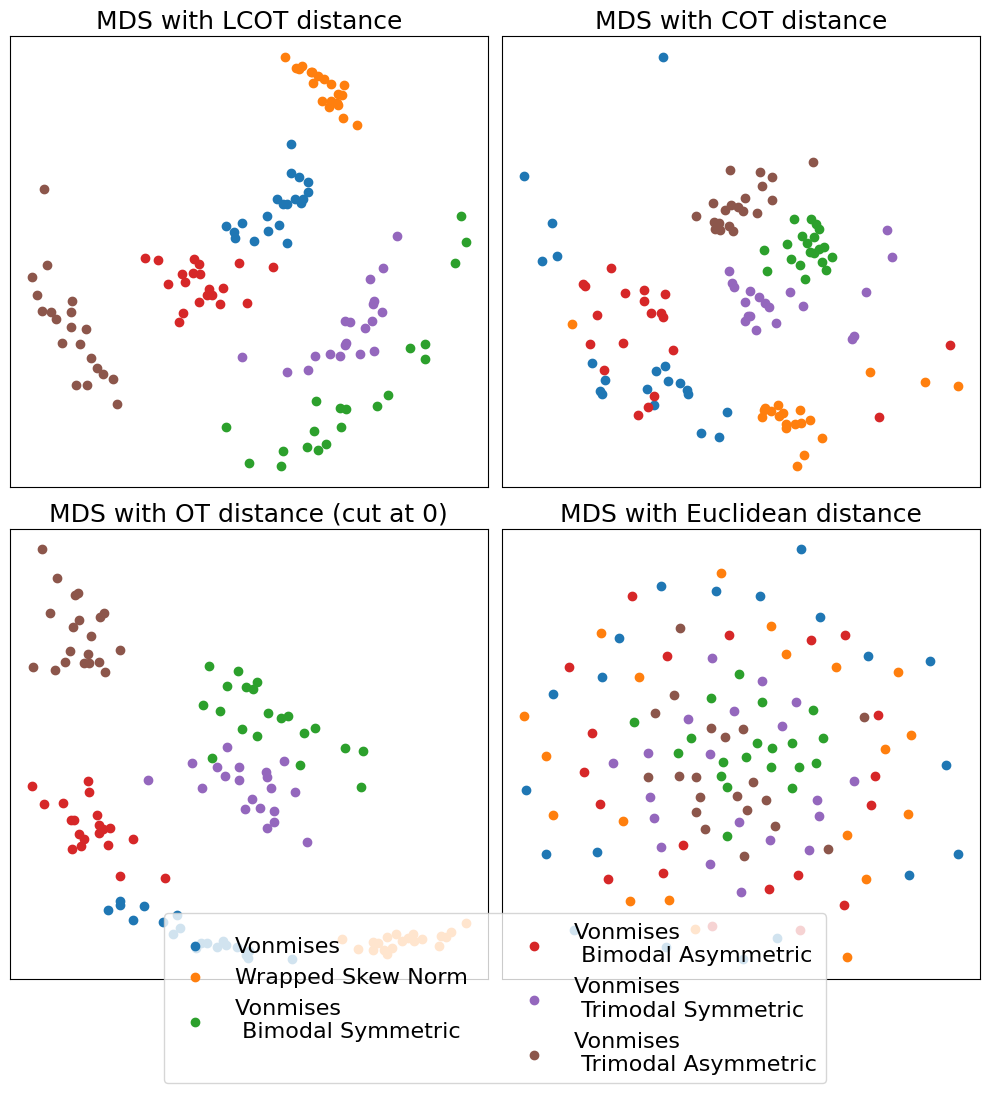

In [29]:
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=1)
lower_dimensional_points_LCOT = mds.fit_transform(mat_lin_COT)
lower_dimensional_points_COT = mds.fit_transform(mat_COT)
lower_dimensional_points_OT = mds.fit_transform(mat_OT)
lower_dimensional_points_euclidean = mds.fit_transform(mat_euclidean)


fig, ax = plt.subplots(2,2, figsize = (10,10))
for i in range(6):
  ax[0,0].scatter(lower_dimensional_points_LCOT[label==i,0], lower_dimensional_points_LCOT[label==i,1], label = titles[i])
  ax[0,0].set_title('MDS with LCOT distance',fontsize=18)
  ax[0,1].scatter(lower_dimensional_points_COT[label==i,0], lower_dimensional_points_COT[label==i,1], label = titles[i])
  ax[0,1].set_title('MDS with COT distance',fontsize=18)
  ax[1,0].scatter(lower_dimensional_points_OT[label==i,0], lower_dimensional_points_OT[label==i,1], label = titles[i])
  ax[1,0].set_title('MDS with OT distance (cut at 0)',fontsize=18)
  ax[1,1].scatter(lower_dimensional_points_euclidean[label==i,0], lower_dimensional_points_euclidean[label==i,1],label = titles[i])
  ax[1,1].set_title('MDS with Euclidean distance',fontsize=18)

for i in range(2):
  for j in range(2):
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
fig.tight_layout()

lines, labels = ax[1,1].get_legend_handles_labels()
fig.legend(lines, labels,loc='lower center',fontsize=16,ncol=2,bbox_to_anchor=(.5,-0.1))